In [103]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch
torch.backends.cudnn.benchmark = True

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    NormalizeIntensityd,
    GaussianSmoothd,
    ScaleIntensityd,
    RandSpatialCropd,
    RandGaussianNoised,
    ToTensord,
    RandCropByLabelClassesd,
    RandCropd,
    RandGaussianSmoothd,
    CastToTyped
)
from monai.networks.layers.factories import Act, Norm
from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from src.models import UNet_CBAM

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

import torch.nn as nn
import torch.nn.functional as F
from monai.losses import TverskyLoss
from src.dataset.dataset import create_dataloaders
from src.dataset.dataset_csv import create_dataloaders_from_csv
from pathlib import Path
import torch.optim as optim

class_info = {
    0: {"name": "background", "weight": 0},  # weight 없음
    1: {"name": "apo-ferritin", "weight": 1000},
    2: {"name": "beta-amylase", "weight": 100}, # 4130
    3: {"name": "beta-galactosidase", "weight": 1500}, #3080
    4: {"name": "ribosome", "weight": 1000},
    5: {"name": "thyroglobulin", "weight": 1500},
    6: {"name": "virus-like-particle", "weight": 1000},
}

# 가중치에 비례한 비율 계산
raw_ratios = {
    k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
    for k, v in class_info.items()
}
total = sum(raw_ratios.values())
ratios = {k: v / total for k, v in raw_ratios.items()}

# 최종 합계가 1인지 확인
final_total = sum(ratios.values())
print("클래스 비율:", ratios)
print("최종 합계:", final_total)

# 비율을 리스트로 변환
ratios_list = [ratios[k] for k in sorted(ratios.keys())]
print("클래스 비율 리스트:", ratios_list)

MONAI version: 1.4.0
Numpy version: 1.26.3
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\ProgramData\anaconda3\envs\czii\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.0
scipy version: 1.15.1
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.1
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For d

# Dataset, Loader

In [104]:
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianSmoothd,
    ToTensord, RandCropByLabelClassesd
)

from monai.data import Dataset, DataLoader, CacheDataset
import os
import numpy as np
import torch
from torch.utils.data import Subset

import pandas as pd
import os

import os
import pandas as pd
from sklearn.model_selection import train_test_split

def create_train_val_csv(
    dataset_dir,
    original_csv_path,
    train_csv_path,
    val_csv_path,
    test_size=0.2,
    random_state=42,
    file_extension=".npy"
):
    """
    Create train.csv and val.csv from dataset directory.

    Args:
        dataset_dir (str): The root directory containing 'images' and 'labels'.
        train_csv_path (str): Output path for train CSV.
        val_csv_path (str): Output path for validation CSV.
        test_size (float): Proportion of data to use for validation.
        random_state (int): Seed for reproducibility.
        file_extension (str): File extension for data files (default: '.npy').
    """
    image_dir = os.path.join(dataset_dir, "images")
    label_dir = os.path.join(dataset_dir, "labels")

    # Ensure directories exist
    if not os.path.exists(image_dir) or not os.path.exists(label_dir):
        raise ValueError("Image or label directory does not exist in the dataset folder.")

    # Gather all files in the image directory
    img_files = [f for f in os.listdir(image_dir) if f.endswith(file_extension)]
    data = []

    for img_file in img_files:
        image_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, img_file)
        
        # Check if label file exists
        if not os.path.exists(label_path):
            print(f"Warning: Label file missing for {img_file}. Skipping.")
            continue
        
        data.append({"image": image_path, "label": label_path})

    # Split into train and validation sets
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=random_state)

    # Save to CSV
    pd.DataFrame(data).to_csv(original_csv_path, index=False)
    pd.DataFrame(train_data).to_csv(train_csv_path, index=False)
    pd.DataFrame(val_data).to_csv(val_csv_path, index=False)

    print(f"Train CSV created at: {data}")
    print(f"Train CSV created at: {train_csv_path}")
    print(f"Validation CSV created at: {val_csv_path}")

def create_inference_dataloader(img_dir, label_dir, non_random_transforms=None, random_transforms=None, batch_size=16, num_workers=4):
    data = []
    image = np.load(img_dir)
    data.append({"image": image})
    
    ds = CacheDataset(data=data, transform=non_random_transforms, cache_rate=0.8)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return loader    

def make_dataset_from_csv(csv_file, non_random_transforms=None, random_transforms=None):
    import pandas as pd
    from monai.data import Dataset, CacheDataset
    import numpy as np
    
    # CSV 읽기
    df = pd.read_csv(csv_file)
    
    # 경로에서 데이터를 읽어와 CacheDataset에 적합한 형식으로 변환
    files = []
    for _, row in df.iterrows():
        files.append({
            "image": np.load(row["image"]),  # CSV에서 'image' 경로로 .npy 파일 로드
            "label": np.load(row["label"])   # CSV에서 'label' 경로로 .npy 파일 로드
        })

    # CacheDataset 생성
    ds = CacheDataset(data=files, transform=non_random_transforms, cache_rate=0.8)
    ds = Dataset(data=ds, transform=random_transforms)
    
    return ds

def make_dataloader_from_csv(csv_file, non_random_transforms=None, random_transforms=None, batch_size=16, num_workers=4, num_repeat=3):
    ds = make_dataset_from_csv(csv_file, non_random_transforms, random_transforms)
    indices = torch.arange(len(ds)).repeat(num_repeat)  # 각 데이터를 num_repeat번 호출
    subset = Subset(ds, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    return loader

def create_dataloaders_from_csv(train_csv, 
                                val_csv, 
                                train_non_random_transforms=None,
                                val_non_random_transforms=None,
                                train_random_transforms=None,
                                val_random_transforms=None,
                                batch_size=16,
                                num_workers=4,
                                train_num_repeat=3,
                                val_num_repeat=4):
    train_loader = make_dataloader_from_csv(train_csv, train_non_random_transforms, train_random_transforms, batch_size, num_workers, train_num_repeat)
    val_loader = make_dataloader_from_csv(val_csv, val_non_random_transforms, val_random_transforms, batch_size, num_workers, val_num_repeat)
    
    
    return train_loader, val_loader

# Loss function

In [105]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Dict, Optional, Tuple, Sequence

# -----------------------------------------------------------------------------------
# 0) DFLoss (분포 기반 좌표 학습)
# -----------------------------------------------------------------------------------
class DFLoss(nn.Module):
    """
    DFL (Distribution Focal Loss), 좌표 offset을 0~reg_max 범위로 보고,
    floor와 floor+1 bin 사이를 나누어 CrossEntropy를 계산하는 방식.
    """
    def __init__(self, reg_max=16) -> None:
        super().__init__()
        self.reg_max = reg_max

    def forward(self, pred_dist: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        pred_dist: (N, reg_max)  # 각 coordinate별 reg_max 로짓
        target: (N,)  # 실값 (0 <= t < reg_max)
        
        return: (N,) shape의 loss (coordinate별)
        """
        # clamp to valid range (ex: 0 ~ reg_max-1)
        target = target.clamp_(0, self.reg_max - 1 - 0.01)

        tl = target.long()       # floor index
        tr = tl + 1              # floor+1
        wl = tr - target         # weight for left bin
        wr = 1 - wl              # weight for right bin

        # Cross Entropy를 각각 bin에 대해 계산
        # pred_dist.shape = (N, reg_max)
        # CE에는 레이블이 정수여야 하므로, tl, tr 둘을 이용해 2번 계산
        loss_l = F.cross_entropy(pred_dist, tl, reduction="none") * wl
        # tr이 reg_max를 넘어갈 수 있으므로 clamp
        tr = tr.clamp(max=self.reg_max - 1)
        loss_r = F.cross_entropy(pred_dist, tr, reduction="none") * wr

        # 두 bin 손실 합산
        loss = loss_l + loss_r  # (N,)
        return loss


# ------------------------- Fixed Sphere IoU Functions -------------------------
def sphere_intersection_volume(r1: torch.Tensor, r2: torch.Tensor, d: torch.Tensor) -> torch.Tensor:
    """
    두 구(반지름 r1, r2), 중심 거리 d에서 교집합 부피를 반환.
    r1, r2, d는 동일한 shape를 가져야 함.
    """
    no_overlap = (d >= (r1 + r2))
    contained = (d <= (r1 - r2).abs())
    
    inter_vol = torch.zeros_like(d)
    v1 = (4.0 / 3.0) * math.pi * (r1 ** 3)
    v2 = (4.0 / 3.0) * math.pi * (r2 ** 3)
    
    # Case 1: 완전히 포함
    inside_mask = contained & (~no_overlap)
    inter_vol[inside_mask] = torch.min(v1[inside_mask], v2[inside_mask])
    
    # Case 2: 부분 교차
    partial = ~(no_overlap | contained)
    if partial.any():
        dp = d[partial]
        r1p = r1[partial]
        r2p = r2[partial]
        term = (r1p + r2p - dp) ** 2
        numerator = math.pi * term * (dp ** 2 + 2 * dp * (r1p + r2p) - 3 * (r1p ** 2 + r2p ** 2) + 6 * r1p * r2p)
        vol = numerator / (12.0 * dp + 1e-9)
        vol = torch.clamp_min(vol, 0.)
        inter_vol[partial] = vol
    
    return inter_vol

def sphere_iou(sphere1: torch.Tensor, sphere2: torch.Tensor) -> torch.Tensor:
    """
    sphere1: (N, 4) (x, y, z, r)
    sphere2: (M, 4) (x, y, z, r)
    return: IoU (N, M)
    """
    c1, r1 = sphere1[..., :3], sphere1[..., 3].clamp_min(1e-6)  # 반경이 0이 되지 않도록 방지
    c2, r2 = sphere2[..., :3], sphere2[..., 3].clamp_min(1e-6)

    d = torch.norm(c1 - c2, dim=-1)  # (...,)

    # 반경이 d와 동일한 shape으로 브로드캐스팅되도록 처리
    if r1.dim() < d.dim():
        r1 = r1.unsqueeze(-1)
    if r2.dim() < d.dim():
        r2 = r2.unsqueeze(-1)
    r1 = r1.expand_as(d)
    r2 = r2.expand_as(d)

    # 교집합 볼륨 계산
    inter_vol = sphere_intersection_volume(r1, r2, d)

    # 개별 구의 볼륨
    v1 = (4.0 / 3.0) * math.pi * (r1 ** 3)
    v2 = (4.0 / 3.0) * math.pi * (r2 ** 3)

    # 합집합 볼륨
    union_vol = v1 + v2 - inter_vol

    # NaN 방지 (union_vol이 0이 되는 경우를 방지)
    return inter_vol / (union_vol + 1e-6)




# -----------------------------------------------------------------------------------
# 2) dist2sphere (DFL -> (x,y,z,r)) 함수
# -----------------------------------------------------------------------------------
def dist2sphere(pred_dist: torch.Tensor, anchors_3d: torch.Tensor, reg_max: int):
    """
    pred_dist: (B, A, 4*reg_max) => 4 coords * reg_max bins
    anchors_3d: (B, A, 3) or (A,3)
    return: (B, A, 4) => (x, y, z, r)
    """
    B, A, C = pred_dist.shape
    assert C == 4 * reg_max, f"pred_dist shape mismatch: {C} vs 4*{reg_max}"

    dist_4d = pred_dist.view(B, A, 4, reg_max)  # (B,A,4,reg_max)
    dist_prob = F.softmax(dist_4d, dim=3)       # (B,A,4,reg_max)
    bin_index = torch.arange(reg_max, device=pred_dist.device, dtype=pred_dist.dtype)
    dist_val = (dist_prob * bin_index).sum(dim=3)  # (B,A,4)

    # anchors_3d shape = (B,A,3) or broadcast
    xyz = anchors_3d[..., :3] + dist_val[..., :3]
    r   = dist_val[..., 3:].clamp_min(0.)
    return torch.cat([xyz, r], dim=-1)  # (B,A,4)


# -----------------------------------------------------------------------------------
# 3) 개선된 TaskAlignedAssigner3D (margin 적용)
# -----------------------------------------------------------------------------------
def select_candidates_in_spheres(
    anc_points: torch.Tensor,
    gt_spheres: torch.Tensor,
    margin_factor: float = 0.1
) -> torch.Tensor:
    """
    anchor center가 구 중심에서 거리 <= (r * (1 + margin_factor)) 이면 candidate
    anc_points: (n_anchors, 3) 또는 (B, n_anchors, 3)
    gt_spheres: (B, n_max_boxes, 4)
    returns: (B, n_max_boxes, n_anchors) bool/float
    """
    B, n_g, _ = gt_spheres.shape
    n_anchors = anc_points.shape[0]

    if n_g == 0:
        return torch.zeros((B, 0, n_anchors), device=anc_points.device)  # GT가 없을 때 예외 처리

    centers = gt_spheres[..., :3]  # (B, n_g, 3)
    radii = gt_spheres[..., 3].clamp_min(0.)  # (B, n_g)

    # 차원 확장
    cent_3d = centers.unsqueeze(2)  # (B, n_g, 1, 3)

    if anc_points.dim() == 2:
        anc_3d = anc_points.unsqueeze(0).unsqueeze(0)  # (1, 1, nA, 3)
    else:
        anc_3d = anc_points.unsqueeze(1)  # (B, 1, nA, 3)

    d = (anc_3d - cent_3d).pow(2).sum(-1).sqrt()  # (B, n_g, nA)
    r_expanded = radii.unsqueeze(-1) * (1.0 + margin_factor)  # (B, n_g, 1)
    mask = (d <= r_expanded)

    return mask.float()


import torch
import torch.nn as nn
from typing import Optional

class TaskAlignedAssigner3D(nn.Module):
    """
    A task-aligned assigner for 3D sphere detection.
    Combine cls^alpha * IoU^beta, pick top-k anchors for each GT,
    handle multi-assign by picking the GT with highest IoU for that anchor.
    """

    def __init__(
        self,
        topk=30,
        num_classes=1,
        alpha=1.0,
        beta=6.0,
        iou_weight=3.0,
        cls_weight=1.0,
        margin_factor=0.2,
        eps=1e-9
    ):
        super().__init__()
        self.topk = topk
        self.num_classes = num_classes
        self.alpha = alpha
        self.beta = beta
        self.iou_weight = iou_weight
        self.cls_weight = cls_weight
        self.margin_factor = margin_factor
        self.eps = eps

    @torch.no_grad()
    def assign(
        self,
        pd_scores: torch.Tensor,    # (B, A, nc) raw cls logits
        pd_spheres: torch.Tensor,   # (B, A, 4)
        anc_points: torch.Tensor,   # (A, 3) 실제 anchor center
        gt_spheres: torch.Tensor,   # (B, n_max_boxes, 4)
        gt_classes: torch.Tensor,   # (B, n_max_boxes)
    ):
        """
        Returns:
            fg_mask: (B, A) bool
            box_target: (B, A, 4)
            cls_target: (B, A, nc)
        """
        B, A, nc = pd_scores.shape
        n_max_boxes = gt_spheres.shape[1]
        device = pd_scores.device

        if n_max_boxes == 0:
            # no GT
            fg_mask = torch.zeros((B, A), dtype=torch.bool, device=device)
            box_target = torch.zeros((B, A, 4), device=device)
            cls_target = torch.zeros((B, A, nc), device=device)
            return fg_mask, box_target, cls_target

        # 1) select_candidates_in_spheres => margin_factor 적용
        #    anc_points: (A,3), gt_spheres: (B, n_max, 4)
        mask_in_spheres = select_candidates_in_spheres(
            anc_points, gt_spheres, margin_factor=self.margin_factor
        )  # shape (B, n_max, A)

        # 2) compute alignment metric => (cls^alpha * iou^beta)
        align_metric, overlaps = self.get_box_metrics(
            pd_scores, pd_spheres, gt_classes, gt_spheres, mask_in_spheres
        )

        # 3) top-k mask
        mask_topk = self.select_topk_candidates(align_metric, topk_mask=None)
        mask_pos = mask_in_spheres * mask_topk  # (B,n_max,A)

        # 4) select_highest_overlaps => multi-assign 해소
        target_gt_idx, fg_mask, mask_pos = self.select_highest_overlaps(
            mask_pos, overlaps, n_max_boxes
        )
        # 5) get_targets => (cls_target, box_target)
        target_labels, target_spheres, target_scores = self.get_targets(
            gt_classes, gt_spheres, target_gt_idx, fg_mask
        )

        return fg_mask, target_spheres, target_scores

    def get_box_metrics(
        self,
        pd_scores: torch.Tensor,
        pd_spheres: torch.Tensor,
        gt_classes: torch.Tensor,
        gt_spheres: torch.Tensor,
        mask_in_spheres: torch.Tensor
    ):
        """
        overlap => sphere_iou
        cls => pd_scores.sigmoid() for each gt class
        align_metric = cls^alpha * iou^beta
        """
        B, A, nc = pd_scores.shape
        device = pd_scores.device
        n_max_boxes = gt_spheres.shape[1]

        overlaps = torch.zeros((B, n_max_boxes, A), device=device)
        bbox_scores = torch.zeros((B, n_max_boxes, A), device=device, dtype=pd_scores.dtype)

        # compute iou
        for b_i in range(B):
            # pd_spheres[b_i]: (A,4)
            # gt_spheres[b_i]: (n_max_boxes,4)
            # sphere_iou => (A,n_max_boxes)
            ps = pd_spheres[b_i].unsqueeze(1)  # (A,1,4)
            gs = gt_spheres[b_i].unsqueeze(0)  # (1,n_max_boxes,4)
            ious = sphere_iou(ps, gs)          # (A,n_max_boxes)
            overlaps[b_i] = ious.transpose(0,1)  # => (n_max_boxes,A)

        # compute cls score => pd_scores.sigmoid()
        pd_sig = pd_scores.sigmoid()
        for b_i in range(B):
            for g_i in range(n_max_boxes):
                if mask_in_spheres[b_i, g_i].any():
                    cls_idx = int(gt_classes[b_i, g_i].item())
                    if 0 <= cls_idx < nc:
                        # bbox_scores[b_i,g_i,:] = pd_sig[b_i,:, cls_idx]
                        bbox_scores[b_i, g_i] = pd_sig[b_i, :, cls_idx]

        # align_metric
        #   => (cls^alpha) * (iou^beta)
        #   => mask_in_spheres=0 인 곳은 0으로
        align_metric = bbox_scores.pow(self.alpha) * overlaps.pow(self.beta)
        align_metric = align_metric * mask_in_spheres  # outside sphere => 0
        return align_metric, overlaps

    def select_topk_candidates(self, metrics: torch.Tensor, topk_mask: Optional[torch.Tensor]=None, largest=True):
        """
        metrics: (B, n_max_boxes, A)
        => pick top-k anchors per GT box
        return: (B, n_max_boxes, A) mask
        """
        B, n_m, A = metrics.shape
        val, idxs = torch.topk(metrics, self.topk, dim=-1, largest=largest)  # (B,n_m,topk)
        if topk_mask is None:
            topk_mask = (val > self.eps)

        mask = torch.zeros_like(metrics)
        for b_i in range(B):
            for g_i in range(n_m):
                valid_k = topk_mask[b_i, g_i]  # (topk,)
                sel_ind = idxs[b_i, g_i, valid_k]  # anchor indices
                mask[b_i, g_i, sel_ind] = 1.0

        return mask

    def select_highest_overlaps(self, mask_pos, overlaps, n_max_boxes):
        """
        mask_pos: (B, n_max_boxes, A)
        overlaps: (B, n_max_boxes, A)
        => 한 anchor가 여러 GT에 할당된 경우 => overlaps 최대인 GT만
        return:
          target_gt_idx: (B,A)
          fg_mask: (B,A)
          mask_pos => updated
        """
        fg_mask = mask_pos.sum(dim=1)  # (B,A)
        if fg_mask.max() > 1:
            # multi-assign => pick max overlap GT
            max_overlaps_idx = overlaps.argmax(dim=1)  # (B,A)
            new_mask = torch.zeros_like(mask_pos)
            B_, _, A_ = mask_pos.shape
            for b_i in range(B_):
                for a_i in range(A_):
                    g_i = max_overlaps_idx[b_i,a_i]
                    new_mask[b_i, g_i, a_i] = 1.0
            mask_pos = new_mask
            fg_mask = mask_pos.sum(dim=1)

        # target_gt_idx
        target_gt_idx = mask_pos.argmax(dim=1)  # (B,A)
        return target_gt_idx, fg_mask.bool(), mask_pos

    def get_targets(self, gt_classes, gt_spheres, target_gt_idx, fg_mask):
        """
        Return (assigned_labels, assigned_spheres, cls_target)
        """
        B, A = fg_mask.shape
        device = gt_classes.device
        n_max_boxes = gt_spheres.shape[1]

        # gather idx
        batch_ind = torch.arange(B, device=device).view(-1,1).expand(B,A)
        gather_idx = target_gt_idx + batch_ind*n_max_boxes  # (B,A)

        gt_spheres_2d = gt_spheres.view(B*n_max_boxes, 4)
        gt_classes_2d = gt_classes.view(B*n_max_boxes)

        assigned_labels  = gt_classes_2d[gather_idx.reshape(-1)].view(B,A)
        assigned_spheres= gt_spheres_2d[gather_idx.reshape(-1)].view(B,A,4)

        # build cls_target
        nc = self.num_classes
        cls_target = torch.zeros((B, A, nc), device=device)
        for b_i in range(B):
            valid_anchors = fg_mask[b_i].nonzero(as_tuple=True)[0]  # (some_count,)
            for a_i in valid_anchors:
                c_idx = int(assigned_labels[b_i,a_i].item())
                if 0 <= c_idx < nc:
                    cls_target[b_i,a_i,c_idx] = 1.0

        return assigned_labels, assigned_spheres, cls_target



# -----------------------------------------------------------------------------------
# 4) 최종 Loss
# -----------------------------------------------------------------------------------
class YOLOv8SphereLoss3D_Advanced(nn.Module):
    """
    개선된 3D YOLO Loss with:
      - Top-k TaskAlignedAssigner3D (with margin_factor)
      - Sphere IoU
      - Classification (BCE)
      - DFL
    """
    def __init__(
        self,
        num_classes: int = 1,
        reg_max: int = 16,
        iou_weight: float = 3.0,
        cls_weight: float = 1.0,
        dfl_weight: float = 1.0,
        topk: int = 30,
        alpha: float = 1.0,
        beta: float = 6.0,
        margin_factor: float = 0.1,
        device: str = "cuda",
    ):
        super().__init__()
        self.num_classes = num_classes
        self.reg_max = reg_max
        self.iou_weight = iou_weight
        self.cls_weight = cls_weight
        self.dfl_weight = dfl_weight
        self.topk = topk
        self.alpha = alpha
        self.beta = beta
        self.margin_factor = margin_factor
        self.device = device

        # 새 TaskAlignedAssigner3D
        self.assigner = TaskAlignedAssigner3D(
            topk=topk,
            num_classes=num_classes,
            alpha=alpha,
            beta=beta,
            iou_weight=iou_weight,
            cls_weight=cls_weight,
            margin_factor=margin_factor
        )
        # DFL 모듈
        self.dfl = DFLoss(reg_max=reg_max)

    def forward(
        self,
        pred_dist: torch.Tensor,   # (B, A, 4*reg_max)
        pred_cls: torch.Tensor,    # (B, A, nc)
        anchors_3d: torch.Tensor,  # (B, A, 3) or (A,3)
        gt_spheres: List[torch.Tensor],  # list of (n_g, 4)
        gt_classes: List[torch.Tensor],  # list of (n_g,)
    ) -> Dict[str, torch.Tensor]:
        device = pred_dist.device
        B, A, _ = pred_dist.shape

        # decode => (x,y,z,r)
        pred_sphere = dist2sphere(pred_dist, anchors_3d, self.reg_max)  # (B,A,4)
        print("pred_sphere:", pred_sphere.shape)
        # GT stack
        max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
        if max_g == 0:
            # no GT => background
            cls_loss_bg = F.binary_cross_entropy_with_logits(
                pred_cls, torch.zeros_like(pred_cls), reduction='mean')
            return dict(
                loss_total=cls_loss_bg,
                loss_box=torch.tensor(0., device=device),
                loss_cls=cls_loss_bg.detach(),
                loss_dfl=torch.tensor(0., device=device)
            )

        # pad
        s_list, c_list = [], []
        for b in range(B):
            s_ = gt_spheres[b].to(device)
            c_ = gt_classes[b].to(device)
            pad_s = torch.zeros((max_g, 4), device=device)
            pad_c = torch.zeros((max_g,), device=device)
            if s_.shape[0] > 0:
                pad_s[:s_.shape[0]] = s_
                pad_c[:c_.shape[0]] = c_
            s_list.append(pad_s)
            c_list.append(pad_c)
        stacked_spheres = torch.stack(s_list, dim=0)  # (B,max_g,4)
        stacked_classes = torch.stack(c_list, dim=0)  # (B,max_g)

        # Assigner 호출 부분 수정
        fg_mask, box_target, cls_target = self.assigner.assign(
            pd_scores=pred_cls,         # (B, A, nc)
            pd_spheres=pred_sphere,     # (B, A, 4)
            anc_points=anchors_3d,      # (A,3) or (B,A,3)
            gt_spheres=stacked_spheres, # (B, max_g,4)
            gt_classes=stacked_classes  # (B, max_g)
        )
        # FG 마스크가 전부 False인지 체크
        if fg_mask.sum() == 0:
            print("⚠️ FG 마스크가 전부 False입니다. GT와 예측값이 매칭되지 않았을 수 있습니다.")
            print(f"GT 개수: {max_g}, Anchor 개수: {A}")
        # foreground의 총 개수 계산
        pos_count = int(fg_mask.sum().item())  # 혹은 fg_mask.sum().item()

        # classification loss
        cls_loss_full = F.binary_cross_entropy_with_logits(
            pred_cls, cls_target, reduction='none'
        )  # (B,A,nc)
        cls_loss = cls_loss_full.mean()

        if pos_count < 1:
            # no fg
            return dict(
                loss_total=cls_loss,
                loss_box=torch.tensor(0., device=device),
                loss_cls=cls_loss.detach(),
                loss_dfl=torch.tensor(0., device=device)
            )

        # box loss => sphere IoU
        pred_fg = pred_sphere[fg_mask]   # (pos_count,4)
        box_fg  = box_target[fg_mask]    # (pos_count,4)
        ious_fg = sphere_iou(pred_fg, box_fg)
        box_loss = (1. - ious_fg).mean()

        # DFL loss
        # offsets_fg = box_fg - anchors_3d[fg_mask] (for x,y,z), r as is
        if anchors_3d.dim()==2 and anchors_3d.shape[0]==A:
            # broadcast B
            anchors_to_sub = anchors_3d.unsqueeze(0).expand(B,-1,-1)[fg_mask]
        else:
            anchors_to_sub = anchors_3d[fg_mask]
        offsets_fg = torch.zeros_like(box_fg)
        offsets_fg[..., :3] = box_fg[..., :3] - anchors_to_sub[..., :3]
        offsets_fg[..., 3]  = box_fg[..., 3]

        pred_dist_fg = pred_dist[fg_mask].view(-1,4,self.reg_max)  # (pos_count,4,reg_max)

        dfl_val = 0.
        for coord_i in range(4):
            pd_coord = pred_dist_fg[:, coord_i, :]    # (pos_count, reg_max)
            gt_coord = offsets_fg[:, coord_i]         # (pos_count,)
            loss_coord = self.dfl(pd_coord, gt_coord) # (pos_count,)
            dfl_val += loss_coord.mean()
        dfl_val /= 4.

        # 합산
        total_loss = self.iou_weight*box_loss + self.cls_weight*cls_loss + self.dfl_weight*dfl_val

        return dict(
            loss_total=total_loss,
            loss_box=box_loss.detach(),
            loss_cls=cls_loss.detach(),
            loss_dfl=dfl_val.detach()
        )
        
# ------------------------- Anchor Generation Function -------------------------
def generate_anchors_3d(feature_shape: Tuple[int, int, int], stride: int) -> torch.Tensor:
    D, H, W = feature_shape
    grid_z, grid_y, grid_x = torch.meshgrid(
        torch.arange(D, dtype=torch.float32),
        torch.arange(H, dtype=torch.float32),
        torch.arange(W, dtype=torch.float32),
        indexing='ij'
    )
    grid_x = (grid_x + 0.5) * stride
    grid_y = (grid_y + 0.5) * stride
    grid_z = (grid_z + 0.5) * stride
    anchors = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)
    return anchors

In [106]:
import torch
import numpy as np
import cc3d
from monai.data import MetaTensor

def extract_and_convert_3d_bounding_boxes(labels, min_size=5, normalize=True, clip_boxes=True):
    """
    YOLOv8SphereLoss3D_Advanced에서 사용할 수 있도록 GT 변환.

    Args:
        labels (MetaTensor): (B, 1, D, H, W) 형태의 라벨 텐서
        min_size (int): 최소 객체 크기 필터링
        normalize (bool): 0~1 정규화 여부
        clip_boxes (bool): 크롭된 영역을 반영하여 bounding box 조정

    Returns:
        Tuple[List[torch.Tensor], List[torch.Tensor]]: (gt_spheres, gt_classes)
            - gt_spheres: List[Tensor] -> (cx, cy, cz, radius)
            - gt_classes: List[Tensor] -> (class_id,)
    """
    batch_size, _, d, h, w = labels.shape
    gt_spheres = []
    gt_classes = []

    for b in range(batch_size):
        label_map = labels[b, 0].cpu().numpy()  # (D, H, W)
        crop_coords = labels.meta.get("crop_coords", (0, d, 0, h, 0, w))  # 크롭된 영역 좌표
        d_min, d_max, h_min, h_max, w_min, w_max = crop_coords

        objects = []
        for class_id in np.unique(label_map):
            if class_id == 0:
                continue  # 배경 무시

            binary_mask = (label_map == class_id).astype(np.uint8)
            labeled, num_features = cc3d.connected_components(binary_mask, connectivity=26, return_N=True)

            for obj_id in range(1, num_features + 1):
                coords = np.array(np.where(labeled == obj_id))  # (3, num_points)

                if coords.shape[1] < min_size:
                    continue  # 너무 작은 객체 필터링

                z_min, y_min, x_min = coords.min(axis=1)
                z_max, y_max, x_max = coords.max(axis=1)

                # Clipping 적용 (Bounding Box가 크롭된 영역을 벗어나지 않도록 보정)
                if clip_boxes:
                    z_min = max(z_min, d_min)
                    z_max = min(z_max, d_max)
                    y_min = max(y_min, h_min)
                    y_max = min(y_max, h_max)
                    x_min = max(x_min, w_min)
                    x_max = min(x_max, w_max)

                # 중심 좌표 및 크기 계산
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                z_center = (z_min + z_max) / 2
                r_x = (x_max - x_min) / 2
                r_y = (y_max - y_min) / 2
                r_z = (z_max - z_min) / 2
                radius = max(r_x, r_y, r_z)

                # 정규화 (0~1 범위)
                if normalize:
                    x_center = (x_center - w_min) / (w_max - w_min)
                    y_center = (y_center - h_min) / (h_max - h_min)
                    z_center = (z_center - d_min) / (d_max - d_min)
                    radius /= max(w_max - w_min, h_max - h_min, d_max - d_min)  # 최대 길이로 정규화

                objects.append([int(class_id), x_center, y_center, z_center, radius])

        # YOLOv8 Loss 입력 형식으로 변환
        gt_spheres.append(torch.tensor([o[1:] for o in objects], dtype=torch.float32) if objects else torch.empty((0, 4)))
        gt_classes.append(torch.tensor([o[0] for o in objects], dtype=torch.long) if objects else torch.empty((0,), dtype=torch.long))

    return gt_spheres, gt_classes


# NMS

In [107]:
import torch
from typing import Tuple, List

class SphereNMS3D:
    def __init__(
        self,
        conf_thres: float = 0.25,
        iou_thres: float = 0.45,
        max_det: int = 300,
        max_nms: int = 10000,
        multi_label: bool = True,
        max_time: bool = False,
    ):
        """
        3D Sphere NMS implementaion
        Args:
            conf_thres: confidence threshold
            iou_thres: IoU threshold for NMS
            max_det: maximum number of detections per image
            max_nms: maximum number of boxes into NMS
            multi_label: multiple labels per box (adds 0.5ms/img)
            max_time: maximum time for processing
        """
        self.conf_thres = conf_thres
        self.iou_thres = iou_thres
        self.max_det = max_det
        self.max_nms = max_nms
        self.multi_label = multi_label
        self.max_time = max_time
    
    def __call__(
        self,
        prediction: torch.Tensor,
        multi_label: bool = False,
        labels: List[int] = None,
    ) -> List[torch.Tensor]:
        """
        Args:
            prediction: (batch_size, num_boxes, num_classes + 5)
                       마지막 차원: (x, y, z, r, obj_conf, cls1_conf, cls2_conf, ...)
            multi_label: True일 경우 박스당 여러 라벨 허용
            labels: 특정 클래스만 필터링하고 싶을 때 사용
        Returns:
            List[torch.Tensor]: 각 이미지별 detection 결과
                               각 텐서 shape: (num_boxes, 6) - x,y,z,r,conf,cls
        """
        bs = prediction.shape[0]
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > self.conf_thres  # candidates
        
        # Settings
        max_nms = min(self.max_nms, 30000)  # limit to 30K boxes
        max_det = min(self.max_det, 300)  # limit detections per image
        multi_label &= nc > 1  # multiple labels per box
        
        output = [torch.zeros((0, 6), device=prediction.device)] * bs
        
        for xi, x in enumerate(prediction):  # image index, image inference
            # Apply constraints
            x = x[xc[xi]]  # confidence
            
            # If none remain process next image
            if not x.shape[0]:
                continue
                
            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            
            # Box/Scores
            sphere_coords = x[:, :4]  # x,y,z,r
            scores = x[:, 5:]  # cls_conf
                
            # Filter by class
            if labels:
                i = torch.stack([torch.arange(len(scores))] + 
                              [(scores[:, i] > self.conf_thres).nonzero().squeeze() 
                               for i in labels])
            else:
                if multi_label:
                    i = (scores > self.conf_thres).nonzero().T
                else:
                    conf, j = scores.max(1)
                    i = torch.stack((torch.arange(len(j)), j))
                    i = i[:, conf > self.conf_thres]
                    
            # Filter by number
            if i.shape[1] > max_nms:
                scores_i = scores[i[0], i[1]]
                i = i[:, scores_i.argsort(descending=True)[:max_nms]]
            
            # If none remain process next image
            n = i.shape[1]
            if not n:
                continue
                
            scores_i = scores[i[0], i[1]]
            sphere_coords_i = sphere_coords[i[0]]
            j = i[1]
            
            # Sort by score
            sorted_idx = scores_i.argsort(descending=True)
            sphere_coords_i = sphere_coords_i[sorted_idx]
            scores_i = scores_i[sorted_idx]
            j = j[sorted_idx]
            
            # NMS
            keep = []
            while sphere_coords_i.shape[0]:
                keep.append(sphere_coords_i[0])  # Add most confident one
                if len(sphere_coords_i) == 1:
                    break
                    
                # IoU of remaining spheres with the most confident one
                iou = sphere_iou(sphere_coords_i[0:1], sphere_coords_i[1:])
                
                # Remove spheres with IoU > threshold
                sphere_coords_i = sphere_coords_i[1:][iou[0] <= self.iou_thres]
                scores_i = scores_i[1:][iou[0] <= self.iou_thres]
                j = j[1:][iou[0] <= self.iou_thres]
            
            keep = torch.stack(keep)
            
            # Limit detections
            if len(keep) > max_det:
                keep = keep[:max_det]
            
            output[xi] = torch.cat((keep, scores_i[:max_det, None], 
                                  j[:max_det, None].float()), 1)
            
        return output

# Define Model

In [108]:
from __future__ import annotations

import warnings
from collections.abc import Sequence

# 불필요한 import 제거
# from monai.networks.blocks.convolutions import Convolution, ResidualUnit
# from monai.networks.layers.simplelayers import SkipConnection
from monai.networks.layers.factories import Act, Norm

from src.models.unet_block import Encoder, Decoder, get_conv_layer
from src.models.cbam import CBAM3D

import torch
import torch.nn as nn
import torch.nn.functional as F

def autopad(k, p=None):  
    """
    3D 컨볼루션에서 padding을 자동 계산해주기 위한 헬퍼 함수 (optional).
    커널 사이즈가 정수 하나라면 (k,k,k)로 확장, 패딩도 동일하게 적용.
    """
    # 예: k가 3이면 (3,3,3), p=None이면 자동으로 (1,1,1) 세팅
    if isinstance(k, int):
        k = (k, k, k)
    if p is None:
        # same padding
        p = tuple((ki // 2) for ki in k)
    return k, p


class YOLO3DHead(nn.Module):
    """
    3D YOLO Detection Head 예시 스케치
    ----------------------------------
    입력  : (B, in_channels, D, H, W)
    출력  : (B, out_channels, D, H, W)
      - out_channels = nc + 4*reg_max
        (클래스 확률 nc개 + dist 분포(dx,dy,dz,dr) * reg_max)
    """
    def __init__(self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        stride: int,
        norm_name: tuple | str,
        act_name: tuple ,
        reg_max: int = 16,
        dropout: tuple | str | float | None = None,
        ):
        
        super().__init__()
        self.out_channels = out_channels
        self.reg_max = reg_max
        # 최종 출력 채널 수
        self.out_channels = 1 + out_channels + 4 * reg_max

        if hidden_ch is None:
            hidden_ch = in_channels  # 간단히 동일 채널로

        # 예시로 2개의 Conv3dBlock을 쌓고 마지막 Conv3d(커널1)로 out_channels를 뽑도록 구성
        # 필요에 따라 더 복잡한 모듈(C3, SPP, Residual 등)로 확장 가능
        
        self.conv_out = get_conv_layer(
            spatial_dims,
            in_channels=in_channels,
            out_channels=self.out_channels,
            kernel_size=1,
            stride=1,
            conv_only=True,
        )

    def forward(self, x):
        """
        x.shape = (B, in_channels, D, H, W)
        return  = (B, out_channels, D, H, W)
        """
        # 3) 최종 1x1x1 Conv -> (nc + 4*reg_max) 채널
        out = self.conv_out(x)
        return out

class c_Decoder(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        kernel_size: Sequence[int] | int,
        stride: int,
        norm_name: tuple | str,
        act_name: tuple | str = ("leakyrelu", {"inplace": True, "negative_slope": 0.01}),
        dropout: tuple | str | float | None = None,
        conv_only=False,
    ):
        super().__init__()
        self.conv1 = get_conv_layer(
            spatial_dims,
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            norm=norm_name,
            act=act_name,
            dropout=dropout,
            conv_only=conv_only,
            is_transposed=True,
        )
        self.cbam = CBAM3D(channels=out_channels, reduction=8, spatial_kernel_size=3)

    def forward(self, x, skip):
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.cbam(x)
        
        return x

class Detect_Unet(nn.Module):
    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Sequence[int] | int = 3,
        up_kernel_size: Sequence[int] | int = 3,
        act: tuple | str = Act.PRELU,
        norm: tuple | str = Norm.INSTANCE,
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
    ) -> None:
        super().__init__()

        if len(channels) < 2:
            raise ValueError("the length of `channels` should be no less than 2.")
        
        # 기존 코드와 동일한 검사
        delta = len(strides) - (len(channels) - 1)
        if delta < 0:
            raise ValueError("the length of `strides` should equal `len(channels) - 1`.")
        if delta > 0:
            warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")
        
        if isinstance(kernel_size, Sequence) and len(kernel_size) != spatial_dims:
            raise ValueError("the length of `kernel_size` should equal to `dimensions`.")
        if isinstance(up_kernel_size, Sequence) and len(up_kernel_size) != spatial_dims:
            raise ValueError("the length of `up_kernel_size` should equal to `dimensions`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias
        self.adn_ordering = adn_ordering

        # ---------------------
        # Encoder
        # ---------------------
        self.encoder1 = Encoder(
            spatial_dims,
            in_channels,
            channels[0],
            kernel_size,
            strides[0],
            norm,
            act,
            dropout,
        )
        self.encoder2 = Encoder(
            spatial_dims,
            channels[0],
            channels[1],
            kernel_size,
            strides[1],
            norm,
            act,
            dropout,
        )
        self.encoder3 = Encoder(
            spatial_dims,
            channels[1],
            channels[2],
            kernel_size,
            strides[2],
            norm,
            act,
            dropout,
        )
        # encoder4는 strides[3]를 사용할 수 있도록 strides에 4개 값을 넣어주거나, 아래처럼 stride=1로 따로 설정 가능
        # 여기서는 strides에 4개 값을 넣어준다고 가정함
        self.bottleneck = Encoder(
            spatial_dims,
            channels[2],
            channels[3],
            kernel_size,
            1, 
            norm,
            act,
            dropout,
        )

        # self.cbam = CBAM3D(channels=channels[3], reduction=8, spatial_kernel_size=3)
        # ---------------------
        # Decoder
        # ---------------------
        self.decoder3 = c_Decoder(
            spatial_dims,
            channels[3] + channels[2],
            channels[1],
            up_kernel_size,
            strides[2],
            norm,
            act,
            dropout,
        )
        self.decoder2 = c_Decoder(
            spatial_dims,
            channels[1] + channels[1],
            channels[0],
            up_kernel_size,
            strides[1],
            norm,
            act,
            dropout,
        )
        self.decoder1 = c_Decoder(
            spatial_dims,
            channels[0] + channels[0],
            channels[0],
            up_kernel_size,
            strides[0],
            conv_only=True,
            norm_name=None,
        )
        self.head = YOLO3DHead(
            spatial_dims,
            channels[0],
            out_channels,
            kernel_size=1,
            stride=1,
            norm_name=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        
        x4 = self.bottleneck(x3)
        # x4 = self.cbam(x4)

        x = self.decoder3(x4, x3)
        x = self.decoder2(x, x2)
        x = self.decoder1(x, x1)
        x = self.head(x)
        return x


# 모델 실행 환경 설정

In [109]:
# DATA CONFIG
train_loader, val_loader = None, None
train_csv = "./datasets/train.csv"
val_csv = "./datasets/val.csv"
img_size =  64 # Match your patch size
img_depth = 32
n_classes = 7
batch_size = 32 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 2
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 8
val_num_repeat = 10

# MODEL CONFIG
feature_size = [32, 64, 128, 256]
use_checkpoint = True
dropout= 0.25

# LOSS CONFIG
lamda = 0.5
ce_weight = 0.4
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치

# TRAIN CONFIG
num_epochs = 4000
lr = 0.001
accumulation_steps = 1
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

sigma = 1.5
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    # GaussianSmoothd(
    #     keys=["image"],      # 변환을 적용할 키
    #     sigma=[sigma, sigma, sigma]  # 각 축(x, y, z)의 시그마 값
    #     ),
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianSmoothd(
    # keys=["image"],      # 변환을 적용할 키
    # sigma_x = (0.5, sigma), # 각 축(x, y, z)의 시그마 값
    # sigma_y = (0.5, sigma),
    # sigma_z = (0.5, sigma),
    # prob=0.5,
    # ),
])
val_random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    # RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    # RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
    # RandGaussianSmoothd(
    # keys=["image"],      # 변환을 적용할 키
    # sigma_x = (0.0, sigma), # 각 축(x, y, z)의 시그마 값
    # sigma_y = (0.0, sigma),
    # sigma_z = (0.0, sigma),
    # prob=1.0,
    # ),
])


In [ ]:
train_loader, val_loader = create_dataloaders_from_csv(
    train_csv,
    val_csv, 
    train_non_random_transforms = non_random_transforms, 
    val_non_random_transforms=non_random_transforms,
    train_random_transforms=random_transforms,
    val_random_transforms=val_random_transforms,
    batch_size = loader_batch,
    num_workers=0,train_num_repeat=num_repeat, val_num_repeat=val_num_repeat
    )

torch.Size([32, 1, 32, 64, 64])


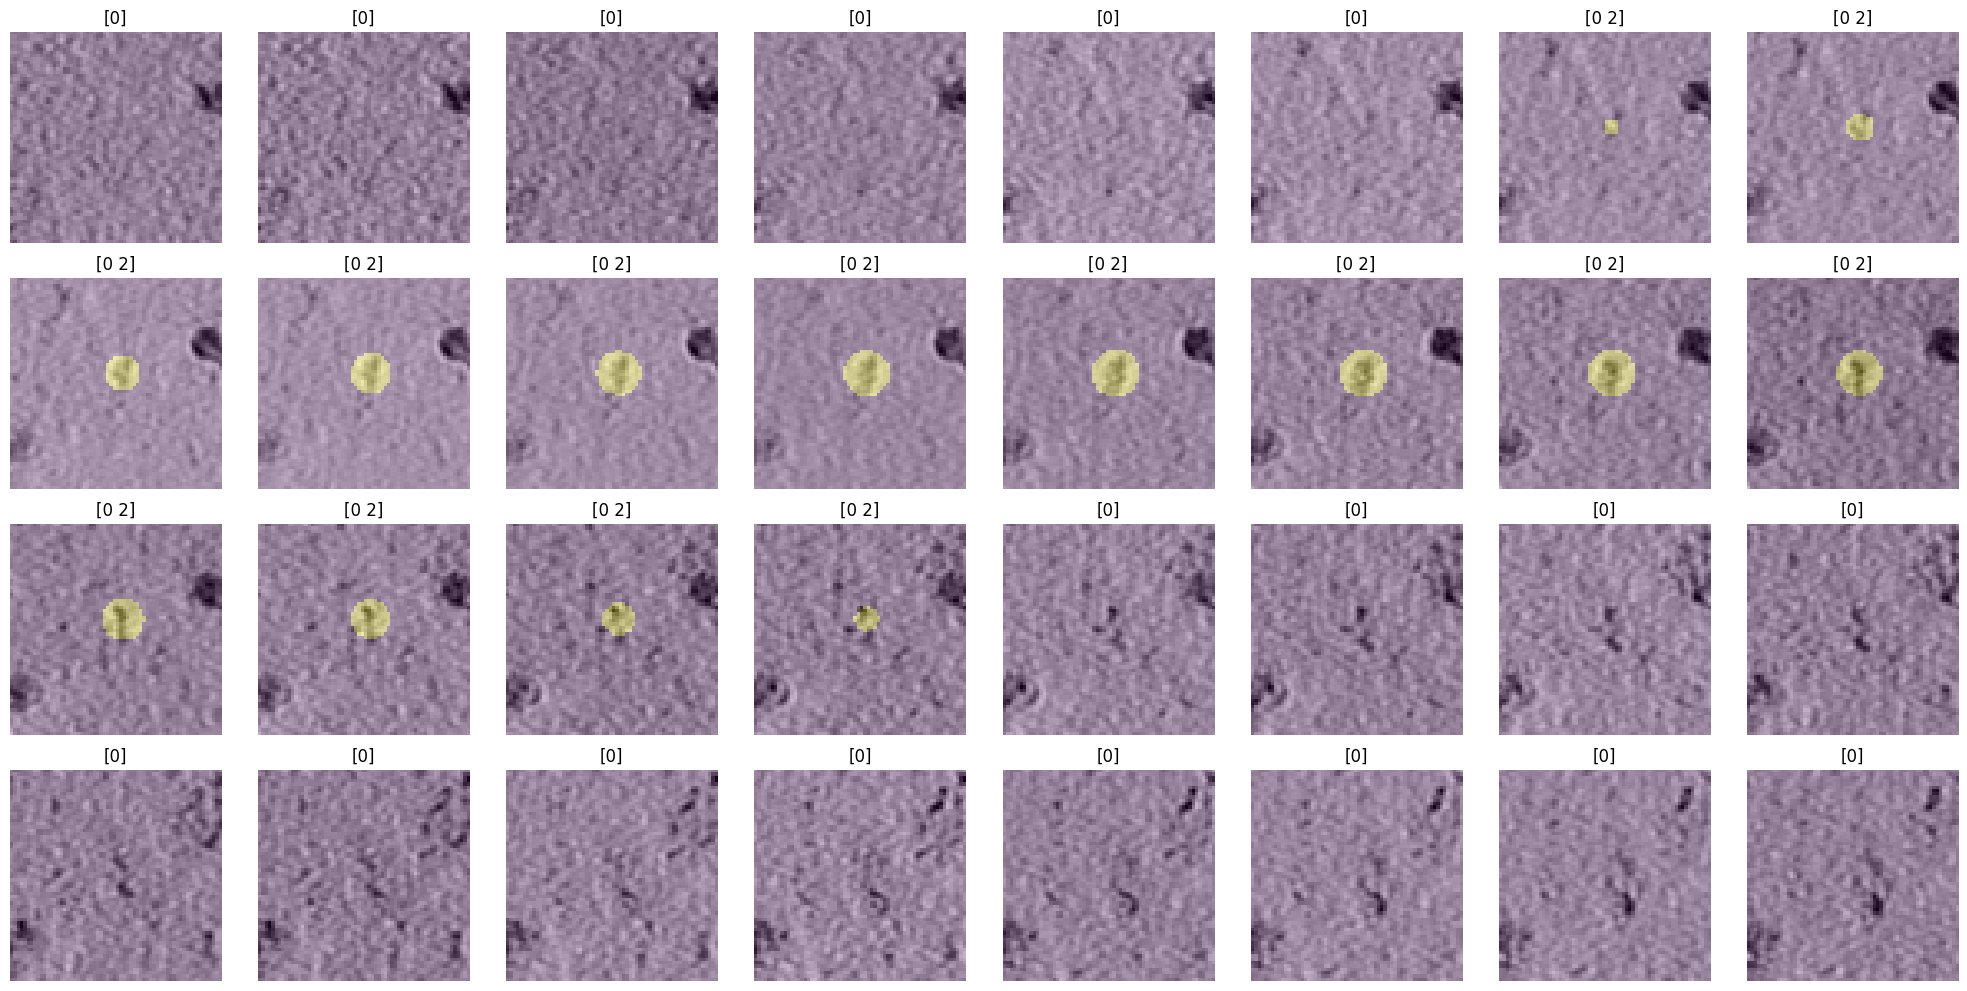

pred_sphere: torch.Size([32, 2048, 4])
loss_total: 6.180161
loss_box: 0.866335
loss_cls: 0.806024
loss_dfl: 2.775133


In [102]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# ========== 1. 데이터 로드 ==========
batch = next(iter(val_loader))
img = batch["image"]
label = batch["label"]

print(img.shape)
num_b = 18
num_slice = 32
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
B, _, D, H, W = img.shape  # 배치 크기, 깊이(D), 높이(H), 너비(W)
stride = 4  # feature map stride
feature_shape = (D // stride, H // stride, W // stride)

# 3D 앵커 생성
anchors_3d = generate_anchors_3d(feature_shape, stride).to(img.device)  # (A,3)
A = anchors_3d.shape[0]
anchors_3d = anchors_3d.unsqueeze(0).expand(B, -1, -1)  # (B, A, 3)

for i in range(num_slice):
    ax = axes[i]
    ax.imshow(img[num_b, 0, i, :, :].cpu().numpy(), cmap='gray')
    ax.imshow(label[num_b, 0, i, :, :].cpu().numpy(), alpha=0.3)
    ax.set_title(f'{np.unique(label[num_b, 0, i, :, :].cpu().numpy())}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# ========== 2. GT 변환 ==========
# GT 변환
gt_spheres, gt_classes = extract_and_convert_3d_bounding_boxes(label, min_size=10, normalize=False)

def pad_gt(gt_spheres, gt_classes, max_g):
    """배치 내 최대 GT 개수를 맞추기 위해 padding 적용"""
    s_list, c_list = [], []
    for b in range(B):
        s_ = gt_spheres[b].to(img.device)
        c_ = gt_classes[b].to(img.device)
        pad_s = torch.zeros((max_g, 4), device=img.device)
        pad_c = torch.zeros((max_g,), device=img.device)
        if s_.shape[0] > 0:
            pad_s[:s_.shape[0]] = s_
            pad_c[:c_.shape[0]] = c_
        s_list.append(pad_s)
        c_list.append(pad_c)
    return torch.stack(s_list, dim=0), torch.stack(c_list, dim=0)

# GT 패딩 적용
max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
stacked_spheres, stacked_classes = pad_gt(gt_spheres, gt_classes, max_g)

# ========== 2. 모델 예측값 생성 (더미 데이터) ==========
pred_dist = torch.randn(B, A, 4 * 16, device=img.device)  # (-∞, +∞) 범위
pred_dist = (pred_dist - pred_dist.min()) / (pred_dist.max() - pred_dist.min())  # [0,1] 정규화

pred_cls = torch.randn(B, A, 7, device=img.device)  # Binary classification (1 class)

# ========== 3. 손실 함수 계산 ==========
loss_fn = YOLOv8SphereLoss3D_Advanced(num_classes=7, reg_max=16, device=img.device)
loss_dict = loss_fn(pred_dist, pred_cls, anchors_3d, stacked_spheres, stacked_classes)

# ========== 4. 손실 출력 ==========
for key, value in loss_dict.items():
    print(f"{key}: {value.item():.6f}")



torch.Size([32, 1, 32, 64, 64])


ValueError: too many values to unpack (expected 4)

# 모델 설정

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Detect_Unet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=feature_size,
    strides=[2, 2, 2, 1],
    kernel_size=3,
    up_kernel_size=3,
    act=Act.PRELU,
    norm=Norm.INSTANCE,
    dropout=dropout,
).to(device)
criterion = None
pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 모델 이름 설정
model_name = model.__class__.__name__

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"{model_name}_denoiiso_maxf{feature_size[-1]}_{img_depth}x{img_size}x{img_size}_e{num_epochs}_lr{lr}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint = None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

NameError: name 'use_checkpoint' is not defined

In [7]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii_SwinUnetR',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "use_checkpoint": use_checkpoint,
        "dropout": dropout,        
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Currently logged in as: woow070840 (waooang). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# 학습

## Scoring

In [44]:
import torch
import torch.nn.functional as F

def decode_predictions(pred_dist, pred_cls, pred_conf, reg_max=16, conf_threshold=0.5):
    """
    YOLO 모델의 예측 결과를 Detection 라벨로 변환.

    Args:
        pred_dist (Tensor): (B, A, 4 * reg_max) → Distance 분포
        pred_cls (Tensor): (B, A, num_classes) → 클래스 점수
        pred_conf (Tensor): (B, A, 1) → Confidence Score
        reg_max (int): 회귀 최대 거리 값
        conf_threshold (float): Confidence Threshold (기본값: 0.5)

    Returns:
        List[Tensor]: 각 배치별 Detection 결과 (N, 4) → (xc, yc, zc, r)
    """
    B, A, num_classes = pred_cls.shape
    decoded_spheres = []

    # Confidence Filtering
    conf_mask = pred_conf.squeeze(-1) > conf_threshold  

    for b in range(B):
        if conf_mask[b].sum() == 0:
            decoded_spheres.append(torch.empty((0, 4)))  
            continue

        valid_anchors = conf_mask[b].nonzero(as_tuple=True)[0]  

        # Distance 회귀 값 변환 (Softmax)
        distances = F.softmax(pred_dist[b, valid_anchors].reshape(-1, 4, reg_max), dim=-1)
        distances = torch.sum(distances * torch.arange(reg_max, device=distances.device).float(), dim=-1)

        # 중심 좌표 및 반지름 계산
        xc, yc, zc = valid_anchors // (A // 3) % 3  
        r = distances[:, -1]  

        # 정규화 (0~1)
        xc /= pred_cls.shape[1]
        yc /= pred_cls.shape[1]
        zc /= pred_cls.shape[1]
        r /= reg_max

        decoded_spheres.append(torch.stack([xc, yc, zc, r], dim=-1))  

    return decoded_spheres

def compute_fbeta_iou(pred_spheres, gt_spheres, beta=2, iou_threshold=0.5):
    """
    F-beta Score 및 mIoU 계산 (Sphere IoU 기반).

    Args:
        pred_spheres (Tensor): (N, 4) 예측된 Detection 결과 (xc, yc, zc, r)
        gt_spheres (Tensor): (M, 4) Ground Truth Detection 결과
        beta (float): F-beta Score의 beta 값
        iou_threshold (float): IoU Threshold (기본값: 0.5)

    Returns:
        fbeta_score (float): F-beta Score
        mean_iou (float): Mean IoU (mIoU)
    """
    if pred_spheres.shape[0] == 0 or gt_spheres.shape[0] == 0:
        return 0.0, 0.0  

    iou_matrix = sphere_iou(pred_spheres, gt_spheres)  

    matched_gt = iou_matrix.max(dim=1)[0] > iou_threshold
    TP = matched_gt.sum().item()
    FP = pred_spheres.shape[0] - TP
    FN = gt_spheres.shape[0] - TP

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    fbeta_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)

    valid_iou = iou_matrix.max(dim=1)[0][matched_gt].mean().item() if TP > 0 else 0.0

    return fbeta_score, valid_iou


## processing

In [45]:
def processing(batch_data, model, criterion, device, reg_max=16, stride=8):
    """
    YOLO 스타일 3D Object Detection을 위한 processing 함수.
    
    Args:
        batch_data: 
            {
                'image': (B, C, D, H, W),
                'label': (B, 1, D, H, W) → Ground Truth Segmentation 라벨
            }
        model: YOLO Detection 모델
        criterion: YOLOv8SphereLoss3D_Advanced
        device: GPU/CPU
        reg_max: Distance 회귀 파라미터
        stride: 앵커 생성 시 기준 stride

    Returns:
        total_loss, (pred_dist, pred_cls, pred_conf)
    """

    # -----------------------------------------------------------
    # 1) 배치에서 이미지 및 GT 라벨 가져오기
    # -----------------------------------------------------------
    images = batch_data['image'].to(device)  # (B, C, D, H, W)
    labels = batch_data['label'].to(device)  # (B, 1, D, H, W)
    
    B, _, D, H, W = images.shape
    
    # -----------------------------------------------------------
    # 2) YOLO 모델 추론
    # -----------------------------------------------------------
    head_output = model(images)  # (B, 1 + num_classes + 4*reg_max, D, H, W)

    # -----------------------------------------------------------
    # 3) 예측값 분리
    # -----------------------------------------------------------
    num_classes = criterion.num_classes  # 클래스 개수

    # Confidence Score (B, 1, D, H, W)
    pred_conf = head_output[:, :1, ...]  

    # Class Probabilities (B, num_classes, D, H, W)
    pred_cls = head_output[:, 1:num_classes + 1, ...]

    # Distance Predictions (B, 4 * reg_max, D, H, W) → (cx, cy, cz, r)
    pred_dist = head_output[:, num_classes + 1:, ...]

    # -----------------------------------------------------------
    # 4) YOLO 스타일로 Reshape
    # -----------------------------------------------------------
    A = (D // stride) * (H // stride) * (W // stride)  # 총 앵커 개수

    pred_conf = pred_conf.permute(0, 2, 3, 4, 1).reshape(B, A, 1)  # (B, A, 1)
    pred_cls = pred_cls.permute(0, 2, 3, 4, 1).reshape(B, A, num_classes)  # (B, A, num_classes)
    pred_dist = pred_dist.permute(0, 2, 3, 4, 1).reshape(B, A, 4 * reg_max)  # (B, A, 4 * reg_max)

    # -----------------------------------------------------------
    # 5) 3D 앵커 생성
    # -----------------------------------------------------------
    feature_shape = (D // stride, H // stride, W // stride)
    anchors_3d = generate_anchors_3d(feature_shape, stride).to(device)  # (A, 3)
    anchors_3d = anchors_3d.unsqueeze(0).expand(B, -1, -1)  # (B, A, 3)

    # -----------------------------------------------------------
    # 6) GT 변환 (Segmentation → Bounding Box)
    # -----------------------------------------------------------
    gt_spheres, gt_classes = extract_and_convert_3d_bounding_boxes(labels, min_size=10, normalize=False)

    def pad_gt(gt_spheres, gt_classes, max_g):
        """배치 내 최대 GT 개수를 맞추기 위해 padding 적용"""
        s_list, c_list = [], []
        for b in range(B):
            s_ = gt_spheres[b].to(device)
            c_ = gt_classes[b].to(device)
            pad_s = torch.zeros((max_g, 4), device=device)
            pad_c = torch.zeros((max_g,), device=device)
            if s_.shape[0] > 0:
                pad_s[:s_.shape[0]] = s_
                pad_c[:c_.shape[0]] = c_
            s_list.append(pad_s)
            c_list.append(pad_c)
        return torch.stack(s_list, dim=0), torch.stack(c_list, dim=0)

    # GT 패딩 적용
    max_g = max(x.shape[0] for x in gt_spheres) if len(gt_spheres) else 0
    stacked_spheres, stacked_classes = pad_gt(gt_spheres, gt_classes, max_g)

    # -----------------------------------------------------------
    # 7) YOLO Loss 계산
    # -----------------------------------------------------------
    loss_dict = criterion(
        pred_dist=pred_dist,
        pred_cls=pred_cls,
        pred_conf=pred_conf,
        anchors_3d=anchors_3d,
        gt_spheres=stacked_spheres,
        gt_classes=stacked_classes
    )

    # Loss 값 가져오기
    total_loss = loss_dict['total_loss']

    return total_loss, (pred_dist, pred_cls, pred_conf)

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    """
    한 epoch 동안 모델을 학습하는 함수 (Detection 라벨 기반).
    
    Args:
        model: 학습할 YOLO 3D Detection 모델
        train_loader: DataLoader (Detection 데이터셋 기반)
        criterion: YOLOv8SphereLoss3D_Advanced 손실 함수
        optimizer: 최적화 알고리즘
        device: GPU/CPU 장치
        epoch: 현재 학습 epoch
        accumulation_steps: 그래디언트 누적 스텝 (default: 4)

    Returns:
        평균 학습 손실 (float)
    """
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화

    with tqdm(train_loader, desc=f'Training Epoch {epoch+1}') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산 (processing 함수 활용)
            total_loss, _ = processing(batch_data, model, criterion, device)

            # 그래디언트 누적을 위한 스케일링
            total_loss = total_loss / accumulation_steps  
            total_loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적
            epoch_loss += total_loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=total_loss.item() * accumulation_steps)  # 현재 손실 출력

    # 에폭 평균 손실 계산
    avg_loss = epoch_loss / len(train_loader)

    # Wandb 로그 기록
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})

    return avg_loss

def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval, ce_weight):
    model.eval()
    val_loss = 0
    fbeta_scores = []
    iou_scores = []

    with torch.no_grad():
        with tqdm(val_loader, desc=f'Validation Epoch {epoch+1}') as pbar:
            for batch_data in pbar:
                total_loss, (pred_dist, pred_cls) = processing(batch_data, model, criterion, device)
                val_loss += total_loss.item()
                pbar.set_postfix(loss=total_loss.item())

                # YOLO 예측을 Detection Box로 변환
                pred_spheres = decode_predictions(pred_dist, pred_cls)
                gt_spheres = batch_data['gt_spheres']  # List[Tensor]

                # F-beta Score 및 mIoU 계산
                for b in range(len(pred_spheres)):
                    fbeta, miou = compute_fbeta_iou(pred_spheres[b], gt_spheres[b])
                    fbeta_scores.append(fbeta)
                    iou_scores.append(miou)

    avg_loss = val_loss / len(val_loader)
    avg_fbeta = np.mean(fbeta_scores)
    avg_iou = np.mean(iou_scores)

    # Wandb 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1, 'val_fbeta': avg_fbeta, 'val_miou': avg_iou})

    print(f"Validation F-beta: {avg_fbeta:.4f}, Validation mIoU: {avg_iou:.4f}")
    
    final_score = avg_fbeta * (1 - ce_weight) + avg_iou * ce_weight
    return avg_loss, final_score

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score, calculate_dice_interval=1,
    accumulation_steps=4, pretrained=False
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_fbeta_score = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval,
            ce_weight=ce_weight
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation F-beta: {overall_mean_fbeta_score:.4f}")

        if val_loss < best_val_loss and overall_mean_fbeta_score > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_fbeta_score
            epochs_no_improve = 0
            if pretrained:
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model_pretrained.pt')
            else:
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_fbeta_score <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve % 6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


In [56]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=10,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
    )

NameError: name 'train_model' is not defined